# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [35]:
# import libraries
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")
print("Shape of data: ", (df.count(), len(df.columns)))
df.printSchema()

Shape of data:  (286500, 18)
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# Display top 5 rows to have overview
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

### Null values

In [5]:
# Calculate total percent null in each column
total_rows = df.count()
df_null = df.select([F.round((F.count(F.when(F.isnan(c) | F.col(c).isNull() | (F.col(c) == ''), c))/total_rows*100), 1).alias(c)
                            for c in df.columns])
df_null.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|  20.4| 0.0|      2.9|   2.9|          0.0|     2.9|  20.4|  0.0|     2.9|   0.0| 0.0|         2.9|      0.0|20.4|   0.0|0.0|      2.9|   2.9|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



It seems abnormal for the columns `userId, firstName, gender,` and `lastName` to have approximately 2.9% null values, as each row represents a unique user. Therefore, in this case, I think we should drop the rows with null values in those columns.

In [6]:
# Investigate userID column
df.select("userID").dropDuplicates().sort("userID").show()

+------+
|userID|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



It seems that in the userID column, we have empty strings representing null values

In [7]:
# Filter row that have userId null
df = df.filter(df['userId'] != '')
df = df.dropna(how='any', subset=['userId'])
print("Number of row before filter: ", total_rows)
print("Number of row after filter: ", df.count())
print("Total row have been dropped: ", total_rows - df.count())

Number of row before filter:  286500
Number of row after filter:  278154
Total row have been dropped:  8346


### Categorical values

In [8]:
str_cols = [column[0] for column in df.dtypes if column[1] == 'string']
str_cols

['artist',
 'auth',
 'firstName',
 'gender',
 'lastName',
 'level',
 'location',
 'method',
 'page',
 'song',
 'userAgent',
 'userId']

In [9]:
# Split column to haft for better visualize
df[str_cols[:6]].describe().show()

+-------+-----------------+---------+---------+------+--------+------+
|summary|           artist|     auth|firstName|gender|lastName| level|
+-------+-----------------+---------+---------+------+--------+------+
|  count|           228108|   278154|   278154|278154|  278154|278154|
|   mean|551.0852017937219|     null|     null|  null|    null|  null|
| stddev|1217.769307916138|     null|     null|  null|    null|  null|
|    min|              !!!|Cancelled| Adelaida|     F|   Adams|  free|
|    max|ÃÂlafur Arnalds|Logged In|   Zyonna|     M|  Wright|  paid|
+-------+-----------------+---------+---------+------+--------+------+



In [10]:
# Split column to haft for better visualize
df[str_cols[6:]].describe().show()

+-------+-----------------+------+-------+--------------------+--------------------+------------------+
|summary|         location|method|   page|                song|           userAgent|            userId|
+-------+-----------------+------+-------+--------------------+--------------------+------------------+
|  count|           278154|278154| 278154|              228108|              278154|            278154|
|   mean|             null|  null|   null|            Infinity|                null| 59682.02278593872|
| stddev|             null|  null|   null|                 NaN|                null|109091.94999910535|
|    min|       Albany, OR|   GET|  About|
ÃÂg ÃÂtti Gr...|"Mozilla/5.0 (Mac...|                10|
|    max|Winston-Salem, NC|   PUT|Upgrade|ÃÂau hafa slopp...|Mozilla/5.0 (comp...|                99|
+-------+-----------------+------+-------+--------------------+--------------------+------------------+



### Numeric value

In [11]:
num_cols = [column for column in df.columns if column not in str_cols]
num_cols

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [12]:
df[num_cols].describe().show()

+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|            length|        registration|         sessionId|            status|                  ts|
+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|  count|            278154|            228108|              278154|            278154|            278154|              278154|
|   mean|114.89918174824018|249.11718197783375|1.535358834085557...|1042.5616241362698|209.10321620397335|1.540958915431858E12|
| stddev| 129.8517293994901| 99.23517921058324| 3.291321616327434E9| 726.5010362219824|30.151388851327788|1.5068287123339083E9|
|    min|                 0|           0.78322|       1521380675000|                 1|               200|       1538352117000|
|    max|              1321|        3024.66567|       1543247354000|              2474|               40

We have `ts` as a timestamp column, but it is currently stored as a numeric value. Therefore, we need to convert it into a proper timestamp format.

#### Process for Timestamp column

In [13]:
# Convert ts column from numeric to timestamp
df = df.withColumn('ts', F.from_unixtime(F.col('ts')/1000))
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|                 ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|2018-10-01 00:01:57|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|153

# Exploratory Data Analysis

### Define Churn

In [14]:
# Investigate list of events we have 
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [15]:
# Create "Churn" column
df = df.withColumn("churn", F.when(F.col("page") == 'Cancellation Confirmation', F.lit(1)).otherwise(0))
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|                 ts|           userAgent|userId|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|2018-10-01 00:01:57|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge

In [16]:
# Show some sample churn user
df.filter(df.churn == 1).select('userId').dropDuplicates().show(5)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
+------+
only showing top 5 rows



In [17]:
# Visualize 1 user to check current value
df.filter(df.userId == 125).show(5)

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+-------------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|                song|status|                 ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+--------------------+------+-------------------+--------------------+------+-----+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|NextSong|1533157139000|      174|    paranoid android|   200|2018-10-12 04:05:44|"Mozilla/5.0 (Mac...|   125|    0|
|The Notorious B.I.G.|Logged In|    Mason|     M|            1|    Hart|230.0338

Although this user has canceled, the past data does not reflect this behavior. Therefore, we need to propagate the churn = 1 label from the future to the past, so that all records for users who have a cancellation confirmation will have churn = 1. This will help improve our analysis by providing a more accurate representation of churn behavior across the user's entire history.

In [18]:
# Spread Churn = 1 to user have been "Cancellation Confirmation"
spread_window = Window.partitionBy("userId").orderBy(F.col("ts").desc()).rangeBetween(Window.unboundedPreceding, 0)
df_clean = df.withColumn("churn", F.max("churn").over(spread_window))

# Visualize 1 user to check after apply spread
df_clean.filter(df_clean.userId == 125).show(5)

+--------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+---------------+------+-------------------+--------------------+------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|                page| registration|sessionId|           song|status|                 ts|           userAgent|userId|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+---------------+------+-------------------+--------------------+------+-----+
|          null|Logged In|    Mason|     M|            9|    Hart|     null| free|Corpus Christi, TX|   PUT|              Cancel|1533157139000|      174|           null|   307|2018-10-12 04:35:18|"Mozilla/5.0 (Mac...|   125|    1|
|          null|Cancelled|    Mason|     M|           10|    Hart|     null|

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Aggregates number of user each group

In [19]:
# Percentage of each group in our dataset
per_df = df_clean.groupBy("churn").count()
per_df = per_df.withColumn("percent", F.round(F.col("count")/df.count()*100, 2))
per_df.show()

+-----+------+-------+
|churn| count|percent|
+-----+------+-------+
|    1| 44864|  16.13|
|    0|233290|  83.87|
+-----+------+-------+



In [20]:
# Percentage of each user in our dataset
user_churn_df = df_clean.select("userId", "churn").dropDuplicates()
per_id_df = user_churn_df.groupBy("churn").count()
per_id_df = per_id_df.withColumn("percent", F.round(F.col("count")/user_churn_df.count()*100, 2))
per_id_df.show()

+-----+-----+-------+
|churn|count|percent|
+-----+-----+-------+
|    1|   52|  23.11|
|    0|  173|  76.89|
+-----+-----+-------+



The gap between the two labels is significant, with about 16% of record having a `Cancellation Confirmation` compare to 83% of records doen't have a `Cancellation Confirmation`, and 23% user having a `Cancellation Confirmation` compare to 76%. Although there is some imbalance, it is not extremely severe. This imbalance could still impact the model's ability to predict churn effectively, as the majority class (non-churn) might dominate the predictions. 

It would be beneficial to explore strategies such as adjusting class weights, using resampling techniques, or employing algorithms designed to handle imbalanced data to improve the model's accuracy for both classes.

#### Number of song each group have been played

In [21]:
# Prepare for visualize
user_df = df_clean.groupBy("userId", "churn").agg(F.count(F.col("sessionId")).alias("count"),\
                                                  F.sum('length').alias("total_hours"))
user_pd_df = user_df.toPandas()
user_pd_df

,userId,churn,count,total_hours
0,100010,0,381,6.694090e+04
1,200002,0,474,9.400888e+04
2,125,1,11,2.089113e+03
3,124,0,4825,1.012312e+06
4,51,1,2464,5.232758e+05
5,7,0,201,3.803409e+04
6,15,0,2278,4.773076e+05
7,54,1,3437,7.113449e+05
8,155,0,1002,1.987793e+05
9,100014,1,310,6.770347e+04


Text(0.5,1,'Total Number of Time')

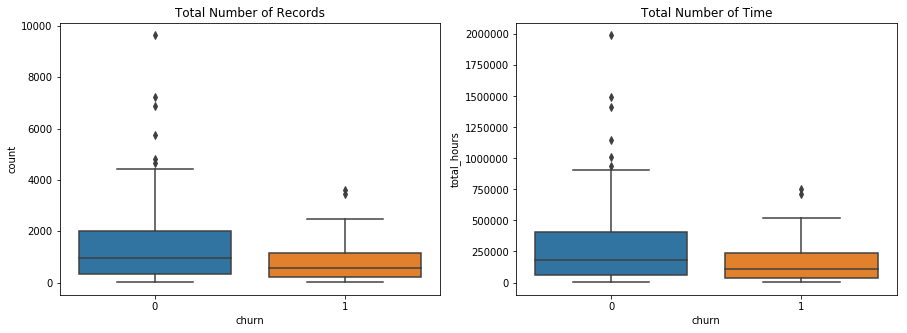

In [22]:
# Plot configuration
fig, axes = plt.subplots(1,2, figsize=(15,5))

# Plot total number of records
sns.boxplot(data = user_pd_df, x='churn', y='count', ax=axes[0])
axes[0].set_title("Total Number of Records")

# Plot total number of times
sns.boxplot(data = user_pd_df, x='churn', y='total_hours', ax=axes[1])
axes[1].set_title("Total Number of Time")

As seen in the plots, there is a noticeable difference in behavior between the two groups. Users with a 'Cancellation Confirmation' (churn = 1) tend to have a lower total number of records and spend less total time compared to users who did not cancel (churn = 0). The median value for both metrics—total number of records and total time spent—is significantly lower for churned users. Additionally, churned users show less variation in their activity, with fewer outliers and a tighter distribution in both plots, suggesting that these users are more consistent in their limited engagement before canceling.

On the other hand, non-churned users (churn = 0) have higher medians and greater variation, which might indicate a wider range of engagement patterns, with some users interacting heavily with the service. This difference in behavior could suggest that lower engagement over time is a potential indicator of churn, which could be valuable for developing predictive models.

#### The distribution of events

In [23]:
events_df = df_clean.groupBy(['page', 'churn']).count().toPandas()
events_df['page'].unique()

array(['Thumbs Up', 'Upgrade', 'Logout', 'Add Friend', 'Error', 'Home',
       'NextSong', 'Submit Upgrade', 'Help', 'Add to Playlist',
       'Save Settings', 'Settings', 'Thumbs Down', 'Roll Advert', 'About',
       'Cancellation Confirmation', 'Cancel', 'Submit Downgrade',
       'Downgrade'], dtype=object)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


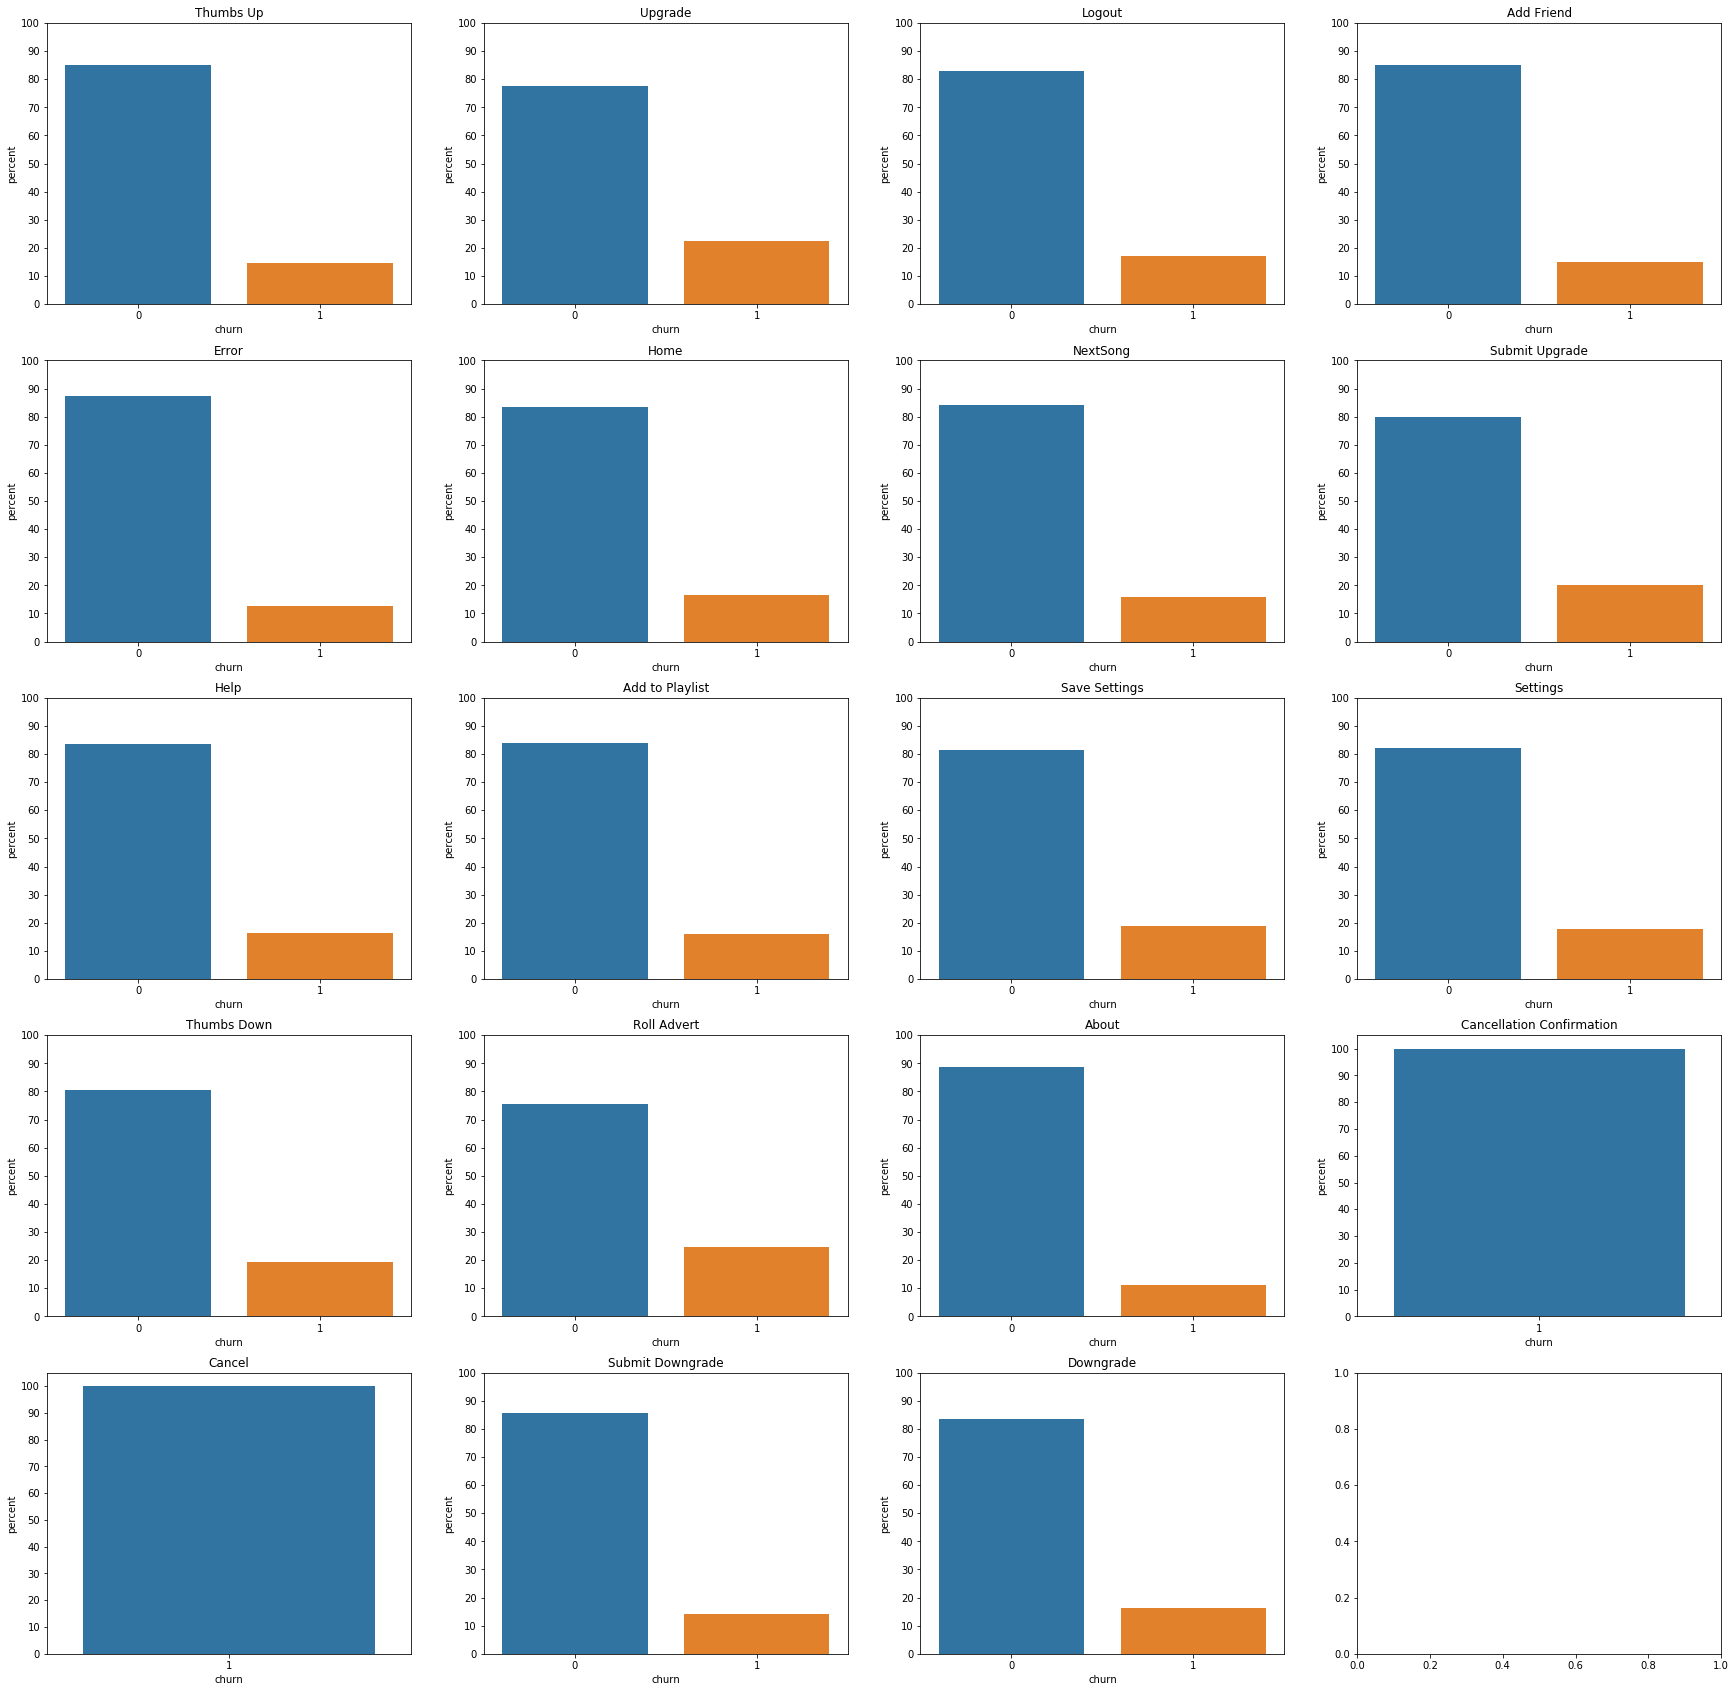

In [24]:
page_unique = events_df['page'].unique()
fig, axes = plt.subplots(5,4, figsize=(30,30))

for idx, value in enumerate(page_unique):
    row = math.floor(idx/4)
    col = idx - 4*row
    a = events_df[events_df['page'] == value]
    a['percent'] = a['count']/a['count'].sum(axis=0)*100
    sns.barplot(data=a, x='churn', y='percent', ax=axes[row,col])
    axes[row,col].set_title(value)
    axes[row,col].set_yticks(range(0, 101, 10))

**Users with Churn = 1:**
- Upgrade & Submit Upgrade: A high percentage of users who churn are interacting with upgrade-related pages. This might suggest they are exploring ways to enhance their experience but may still leave due to dissatisfaction, frustration, or unfulfilled expectations after attempting an upgrade.
- Settings & Save Settings: Interaction with settings pages (including saving settings) could indicate users trying to customize their experience. This might highlight a pain point where users feel the need to adjust settings but ultimately decide to churn.
- Thumbs Down: The presence of "Thumbs Down" suggests negative feedback or dissatisfaction with content or features, which can be an important early warning sign of churn.
- Roll Advert: A high percentage on the "Roll Advert" page may point to users being turned off by advertisements. This could be a key driver for their decision to leave the service.
- Cancel & Cancellation Confirmation: The 100% churn rate on these pages is expected since users explicitly confirm their decision to leave. However, tracking the percentage of users reaching these pages can provide insights into how many were on the verge of cancellation.

**Users with Churn = 0:**
- Thumbs Up: The positive feedback page ("Thumbs Up") being heavily skewed towards non-churners is a good sign that content or services are appreciated, leading to retention.
- Logout, Add Friend: High engagement on pages like "Logout" and "Add Friend" shows that users are actively interacting with their accounts and building relationships, both of which could contribute to long-term retention.
- Home & NextSong: The “Home” and “NextSong” pages, being key interaction points, suggest that users are navigating the service smoothly, which contributes to a good experience and lowers churn risk.
- Error Page: Non-churners may handle issues better, staying even after encountering errors.
- Submit Downgrade: This page’s higher usage among churn = 0 users suggests that downgrading is potentially an alternative to leaving altogether, possibly helping to retain users by offering lower-cost options.

**General Trend:**
Non-churners dominate interactions across most pages, engaging more deeply with the service. Tackling issues like ads, dissatisfaction, and upgrade frustration could reduce churn, while promoting positive interactions like "Thumbs Up" and social features helps retain users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Feature total_interact and total_hours

In [25]:
# Aggregate to get total_interact and total_hours_used
feature1_df = df_clean.groupBy("userId", "churn").agg(F.count(F.col("sessionId")).alias("total_interact"),\
                                                  F.sum('length').alias("total_second"))
feature1_df = feature1_df.withColumn("total_second", F.round(F.col("total_second")/3600))
feature1_df = feature1_df.withColumnRenamed("total_second", "total_hours")
feature1_df.show(4)

+------+-----+--------------+-----------+
|userId|churn|total_interact|total_hours|
+------+-----+--------------+-----------+
|100010|    0|           381|       19.0|
|200002|    0|           474|       26.0|
|   125|    1|            11|        1.0|
|   124|    0|          4825|      281.0|
+------+-----+--------------+-----------+
only showing top 4 rows



#### Feature number of some special pages in pages column 
In this feature, I will count the number of interactions for the following pages: ['Roll Advert', 'Upgrade', 'Settings', 'Thumbs Down', 'About', 'Submit Downgrade', 'Thumbs Up']. These pages were selected based on the logic that they show higher-than-normal interaction percentages for users with churn = 1, and some show high interaction for users with churn = 0

In [26]:
# Filter just keep the pages I interested
interest_page = ['Roll Advert', 'Upgrade', 'Settings', 'Thumbs Down', 'About', 'Submit Downgrade', 'Thumbs Up']
feature2_df = df_clean.filter(df_clean.page.isin(interest_page))
# Double check to correct filter
feature2_df.select("page").drop_duplicates().show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|     Thumbs Down|
|     Roll Advert|
|           About|
|        Settings|
|       Thumbs Up|
|         Upgrade|
+----------------+



In [27]:
# Calculate number of rows of each page
feature2_df = feature2_df.groupBy("userId", "page").count().sort("userId")
# Using pivot to move each page from row to column
feature2_df = feature2_df.groupBy("userId").pivot("page", interest_page).sum("count")
feature2_df = feature2_df.fillna(0)

#### Join group of feature into final dataset

In [28]:
final_df = feature1_df.join(feature2_df, "userId", 'left').fillna(0)
# print("Shape of feature1_df: ", (feature1_df.count(), len(feature1_df.columns)))
# print("Shape of feature2_df: ", (feature2_df.count(), len(feature2_df.columns)))
# print("Shape of final_df: ", (final_df.count(), len(final_df.columns)))
final_df.show(5)

+------+-----+--------------+-----------+-----------+-------+--------+-----------+-----+----------------+---------+
|userId|churn|total_interact|total_hours|Roll Advert|Upgrade|Settings|Thumbs Down|About|Submit Downgrade|Thumbs Up|
+------+-----+--------------+-----------+-----------+-------+--------+-----------+-----+----------------+---------+
|100010|    0|           381|       19.0|         52|      2|       0|          5|    1|               0|       17|
|200002|    0|           474|       26.0|          7|      2|       3|          6|    3|               0|       21|
|   125|    1|            11|        1.0|          1|      0|       0|          0|    0|               0|        0|
|   124|    0|          4825|      281.0|          4|      0|      20|         41|    7|               0|      171|
|    51|    1|          2464|      145.0|          0|      0|      12|         21|    2|               0|      100|
+------+-----+--------------+-----------+-----------+-------+--------+--

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Train/Test Split

In [29]:
# Train_test_split
final_df = final_df.drop("userId")
final_df = final_df.withColumnRenamed("churn", "label")
train_df, validation_df, test_df = final_df.randomSplit(weights=[0.6,0.2,0.2], seed=100)
# print("Shape of final_df: ", (final_df.count(), len(final_df.columns)))
# print("Shape of train_df: ", (train_df.count(), len(train_df.columns)))
# print("Shape of validation_df: ", (validation_df.count(), len(validation_df.columns)))
# print("Shape of test_df: ", (test_df.count(), len(test_df.columns)))

#### Define Preprocessing vs Evaluator

In [30]:
# Preprocessing
feature_cols = final_df.columns[1:]
assembler = VectorAssembler(inputCols = feature_cols, outputCol = "feature_vector")
scaler = StandardScaler(inputCol="feature_vector", outputCol="features_scale_vector", withStd=True)

# Initalize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

#### Define model

In [31]:
# Configuration model
lr = LogisticRegression(featuresCol = 'features_scale_vector', labelCol = 'label')
rf = RandomForestClassifier(featuresCol = 'features_scale_vector', labelCol = 'label')

In [32]:
# Configuration pipeline
lr_pipeline = Pipeline(stages=[assembler, scaler, lr])
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])

**Logistic Regression**

In [36]:
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

lr_crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)
# Run cross-validation, and choose the best set of parameters.
lr_cvModel = lr_crossval.fit(train_df)

**Random Forest**

In [37]:
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .build()

rf_crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)
# Run cross-validation, and choose the best set of parameters.
rf_cvModel = rf_crossval.fit(train_df)

#### Evaluate

When there is a big gap between churn = 0 and churn = 1, this indicates class imbalance where one class (usually churn = 0) dominates the dataset. In such cases, accuracy can be misleading. For example, if 90% of users don't churn, a model that predicts "no churn" for every user will have 90% accuracy but fail to identify the actual churners.

So that, in this case I think we bus me using F1 score because churn prediction is about correctly identifying churners (churn = 1), and F1 score ensures the model performs well on this minority class, making it a better choice than accuracy.

In [40]:
# Evaluate Logistic Regression
lr_prediction = lr_cvModel.transform(validation_df)
print("Logistic Regression Model")
print('F1 for Logistic Regression is:', evaluator.evaluate(lr_prediction, {evaluator.metricName: "f1"}))

# Evaluate Random Forest
rf_prediction = rf_cvModel.transform(validation_df)
print("Random Forest Model")
print('F1 for Logistic Regression is:', evaluator.evaluate(rf_prediction, {evaluator.metricName: "f1"}))

Logistic Regression Model
F1 for Logistic Regression is: 0.5432816537467701
Random Forest Model
F1 for Logistic Regression is: 0.5802325581395349


Now, we can see that Random Forest is the best model!!!

It's easy to understand because Random Forest has many advantages compared to logistic regression, including model complexity, the ability to capture non-linear data, and better generalization.

#### Retrain to the whole training set

In [41]:
# Uninon to get the whole data except testing dataset
train_val_df = train_df.union(validation_df)

# Recreate model and train again
rf = RandomForestClassifier(featuresCol = 'features_scale_vector', labelCol = 'label', numTrees=20)
rf_pipeline = Pipeline(stages=[assembler, scaler, rf])
model = rf_pipeline.fit(train_val_df)

# Evaluate
predictions = model.transform(test_df)
print("The final results when using Random Forest models")
print('F1 for Logistic Regression is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

The final results when using Random Forest models
F1 for Logistic Regression is: 0.6342383107088989


# Conclusion

#### Business Impact:

Our analysis provides valuable insights for Sparkify to address user churn. The page interaction analysis reveals several key areas for improvement:

Customization and UI Enhancements: The high percentage of churners interacting with pages like "Settings" and "Save Settings" suggests that users are actively trying to adjust their experience. Sparkify could focus on enhancing the customization options and improving the user interface to make settings more intuitive and user-friendly.

Content Enrichment: Users who churn often engage with upgrade-related pages. This indicates a potential gap in content or feature offerings. By expanding and diversifying content, Sparkify could better meet user needs and expectations, reducing churn.

Advert Effectiveness: The high interaction with "Roll Advert" among churners suggests that ads may negatively impact user experience. Reducing ad frequency or improving ad relevance could enhance user satisfaction and retention.

#### Difficulty:

Working with PySpark for machine learning was a new experience, presenting a learning curve. The challenges mainly involved data transformations and integrating machine learning workflows. However, overcoming these difficulties has been rewarding and has enhanced my skills in handling large-scale data processing and analysis.

#### Future Implications:

The current model's performance indicates room for improvement. Future work will focus on refining the model to achieve better accuracy and F1 scores. Additionally, further analysis will explore advanced techniques and feature engineering to enhance predictive accuracy and provide deeper insights into user behavior.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### Reference

- https://accredianpublication.medium.com/eda-with-pyspark-1f29b7d1618
- https://spark.apache.org/docs/latest/ml-tuning.html